# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Importing packages 

Below are functions load. 

In [67]:
# --- Core Packages ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Visualization & Dimensionality Reduction ---

from sklearn.decomposition import PCA  # Already imported later
from sklearn import datasets as ds     # Not currently used
from sklearn.manifold import TSNE
import seaborn as sns


# --- Evaluation Metrics & Model Selection ---

from sklearn import metrics
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    recall_score,
    precision_score
)

# --- Statistical Testing and random search ---
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, zscore
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# --- Classifiers ---
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# --- Pipeline & Dimensionality Reduction ---
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# --- Scalers ---
from sklearn.preprocessing import RobustScaler, StandardScaler

# --- Data Loading ---
from worcliver.load_data import load_data


# Loading data

In [68]:
data = load_data()

# Presentation of the data:

In [69]:
# Description of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')

# Counting missing values
missing_values = data.isnull().sum()
total_missing = missing_values.sum()
print(f"Total missing values in the dataset: {total_missing}\n")


# Counting categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}\n")

# Duplicates
duplicate_count = data.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicate_count}")

# Redundant features
zero_variance_count = (data.nunique(dropna=False) == 1).sum()
print(f"Number of constant (zero variance) features: {zero_variance_count}")


# Count of each label (benign/malignant)
label_counts = data['label'].value_counts()
print("Label distribution:")
print(label_counts)


The number of samples: 186
The number of features: 494
Total missing values in the dataset: 0

Number of categorical columns: 1
Number of numerical columns: 493


Number of duplicated rows: 0
Number of constant (zero variance) features: 17
Label distribution:
malignant    94
benign       92
Name: label, dtype: int64


# Visualization of features

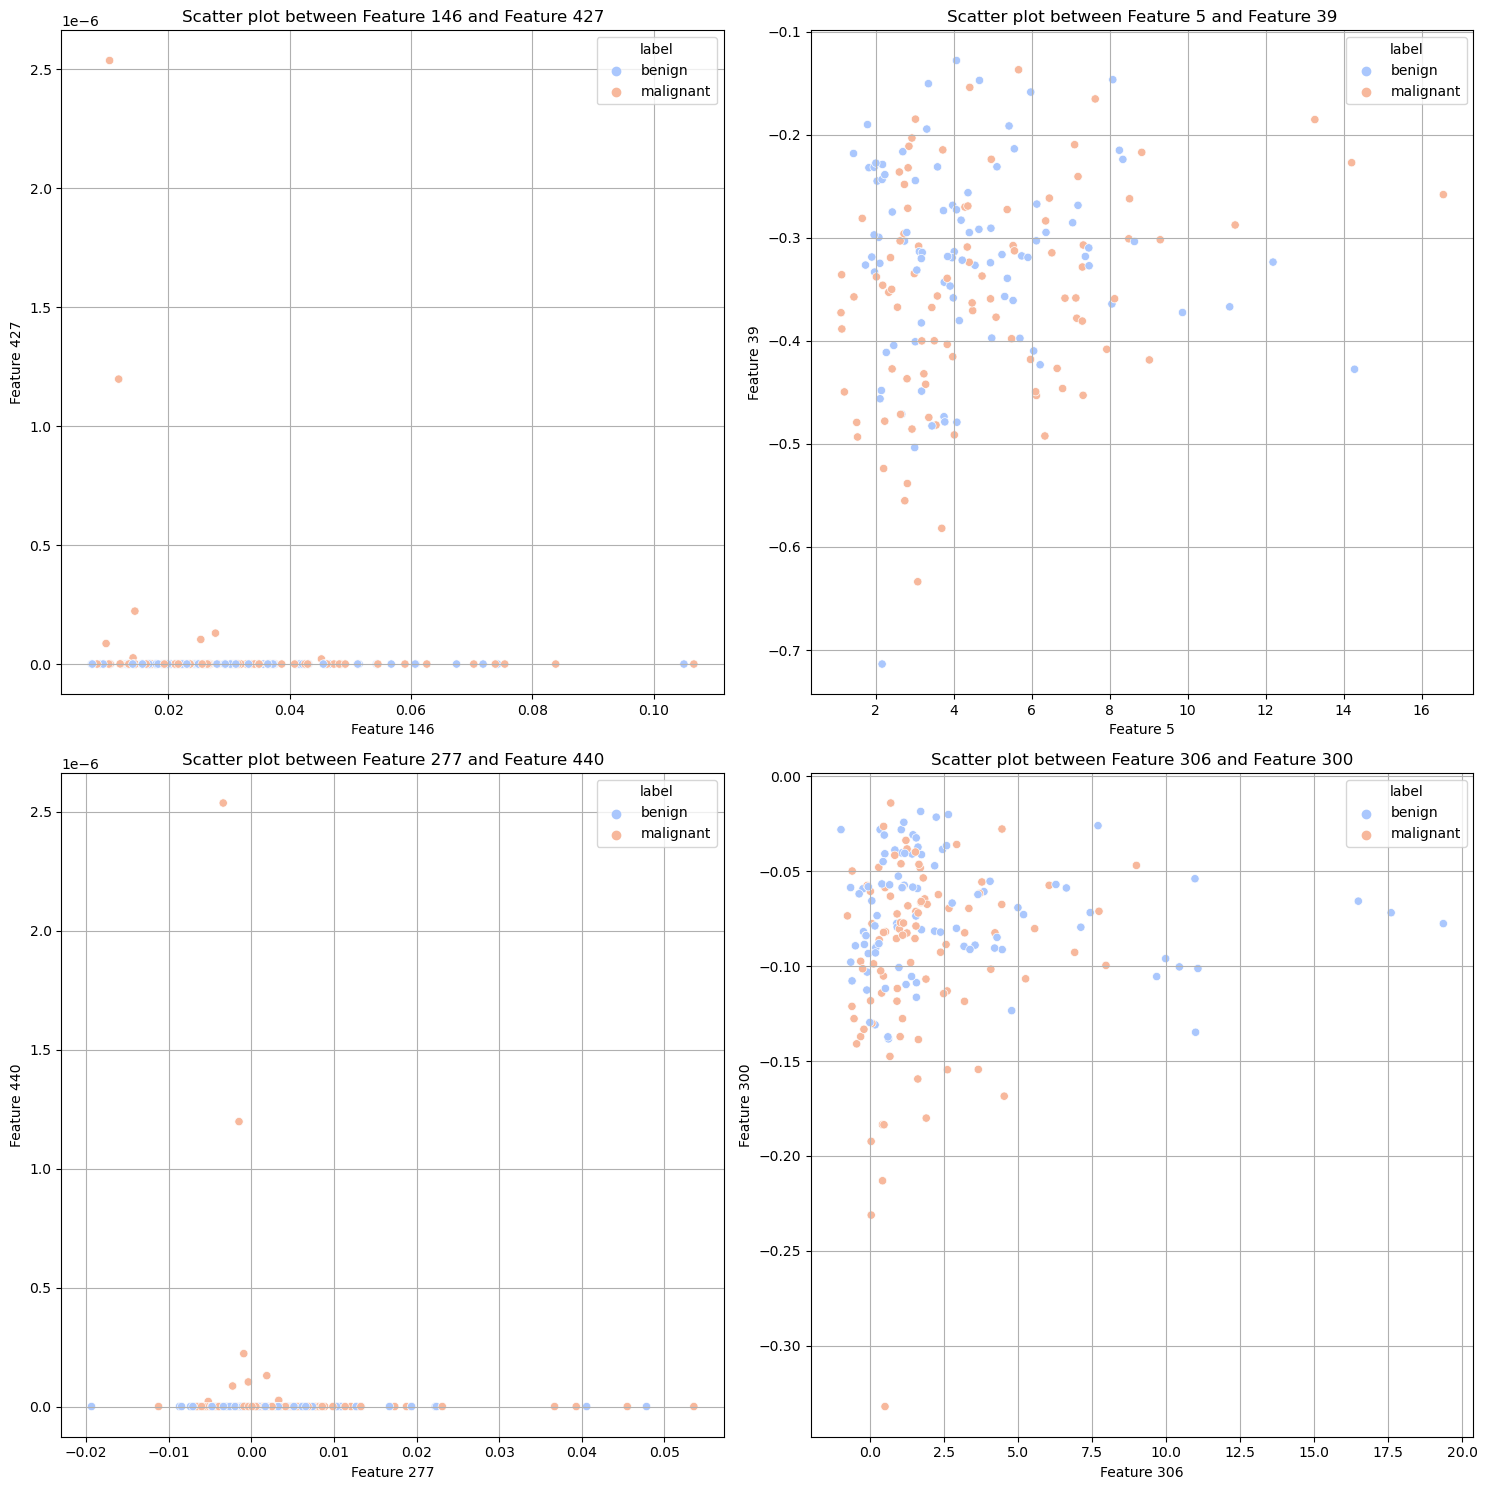

In [70]:
# For loop with a 4 subplots in which 2 features are put against eachother to visualize the data
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    random_columns = np.random.choice(data.columns[:-1], size=2, replace=False)
    
    # Using the index number of the feature for the title
    feature_num1 = list(data.columns).index(random_columns[0]) + 1
    feature_num2 = list(data.columns).index(random_columns[1]) + 1
    
    ax = fig.add_subplot(2, 2, i + 1)
    sns.scatterplot(x=data[random_columns[0]], y=data[random_columns[1]], hue=data['label'], palette='coolwarm', ax=ax)
    ax.set_title(f"Scatter plot between Feature {feature_num1} and Feature {feature_num2}")
    ax.set_xlabel(f"Feature {feature_num1}")
    ax.set_ylabel(f"Feature {feature_num2}")
    ax.grid(True)

plt.tight_layout()
plt.show()


# Preprocessing & Split Dataset


In [71]:
# Copy original data and encode labels: benign → 1, malignant → 0
num_data = data.copy()
num_data['label'] = num_data['label'].map({'benign': 1, 'malignant': 0})

# Separate features
y = num_data['label']
x = num_data.drop(columns=['label'])

# Train/test split (stratified to preserve label balance)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Print dataset shapes
print(f" Training set shape: {x_train.shape}")
print(f" Test set shape: {x_test.shape}")


 Training set shape: (148, 493)
 Test set shape: (38, 493)


# Checking for outliers

In [72]:
# ---- Checking skewness in the training features ----
skewness = x_train.skew()
print("Skewness of all features:")
print(skewness)

# Identifying the highly skewed features (|skewness| > 1)
high_skew = skewness[abs(skewness) > 1] # flagging the features with skewness > 1 or < -1 (highly right- or left-skewed)
print(f"\nNumber of highly skewed features: {len(high_skew)}")

# Outlier detection using the Z-score
z_scores = np.abs(zscore(x_train))
outlier_mask_z = (z_scores > 3)

# Get features with any outliers based on the Z-score
outlier_features_z = x_train.columns[outlier_mask_z.any(axis=0)].tolist()

# Outlier detection using the IQR
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1
outlier_mask_iqr = ((x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR)))

# Get features with any IQR outliers
outlier_features_iqr = x_train.columns[outlier_mask_iqr.any(axis=0)].tolist()
print(f"\nNumber of features with IQR outliers: {len(outlier_features_iqr)}")


Skewness of all features:
PREDICT_original_sf_compactness_avg_2.5D                 -1.336697
PREDICT_original_sf_compactness_std_2.5D                  1.755783
PREDICT_original_sf_rad_dist_avg_2.5D                     0.896949
PREDICT_original_sf_rad_dist_std_2.5D                     1.521164
PREDICT_original_sf_roughness_avg_2.5D                    1.192337
                                                            ...   
PREDICT_original_phasef_phasesym_peak_position_WL3_N5     0.000000
PREDICT_original_phasef_phasesym_range_WL3_N5            -0.879185
PREDICT_original_phasef_phasesym_energy_WL3_N5            2.949009
PREDICT_original_phasef_phasesym_quartile_range_WL3_N5    0.917332
PREDICT_original_phasef_phasesym_entropy_WL3_N5          -0.241095
Length: 493, dtype: float64

Number of highly skewed features: 253

Number of features with IQR outliers: 410


# Selecting significant features

In [73]:
# Select significant features
# Add the label column back to x_train
x_train_with_label = x_train.copy()
x_train_with_label['label'] = y_train

# Separate benign and malignant samples in training data
benign = x_train_with_label[x_train_with_label['label'] == 1]
malignant = x_train_with_label[x_train_with_label['label'] == 0]

# Perform statistical analysis
features = []
sig_features = []

# Loop through all features except 'label'
for feature in x_train_with_label.columns:
    if feature == 'label':  # Skip the label column
        continue
        
    # Data for current feature
    benign_values = benign[feature].dropna()
    malignant_values = malignant[feature].dropna()

    # Ignore constant values within group for Shapiro-Wilk test
    if benign_values.nunique() == 1 or malignant_values.nunique() == 1:
        continue
    
    # Normality test (Shapiro-Wilk test, p < 0.05 means not normally distributed)
    _, p_benign = shapiro(benign_values)
    _, p_malignant = shapiro(malignant_values)
    
    # Determine which test to use
    if p_benign > 0.05 and p_malignant > 0.05:  # Both distributions are normal
        test_type = "t-test"
        stat, p_value = ttest_ind(benign_values, malignant_values, equal_var=False)  # Welch's t-test
    else:
        test_type = "Mann-Whitney U-test"
        stat, p_value = mannwhitneyu(benign_values, malignant_values, alternative='two-sided')
    
    # Save results
    feature_entry = {
        "Feature": feature,
        "Test": test_type,
        "p_value": p_value
    }
    features.append(feature_entry)
    
    # Check for significance (p <= 0.05)
    if p_value <= 0.05:
        sig_entry = feature_entry.copy()
        sig_features.append(sig_entry)

# Convert to DataFrames
features_df = pd.DataFrame(features)
sig_features_df = pd.DataFrame(sig_features)

# Multiple testing correction (False Discovery Rate - Benjamini-Hochberg)
if not features_df.empty:
    reject, p_corrected, alphacSidak, alphacBonf = multipletests(features_df["p_value"], method='fdr_bh')
    features_df["p_value_corrected"] = p_corrected

# Sort significant features by p-value only if there are significant features
if not sig_features_df.empty:
    sig_features_df = sig_features_df.sort_values(by="p_value")

# Print and save results

print(f"\nNumber of significant features: {len(sig_features_df)}")

# Get the list of significant feature names
sig_feature_names = sig_features_df['Feature'].tolist() if not sig_features_df.empty else []

# Select only significant features for training data if there are any
if sig_feature_names:
    x_train_sig = x_train[sig_feature_names].copy()
else:
    print("No significant features found. Cannot create x_train_sig.")



Number of significant features: 153


# T-SNE Plot

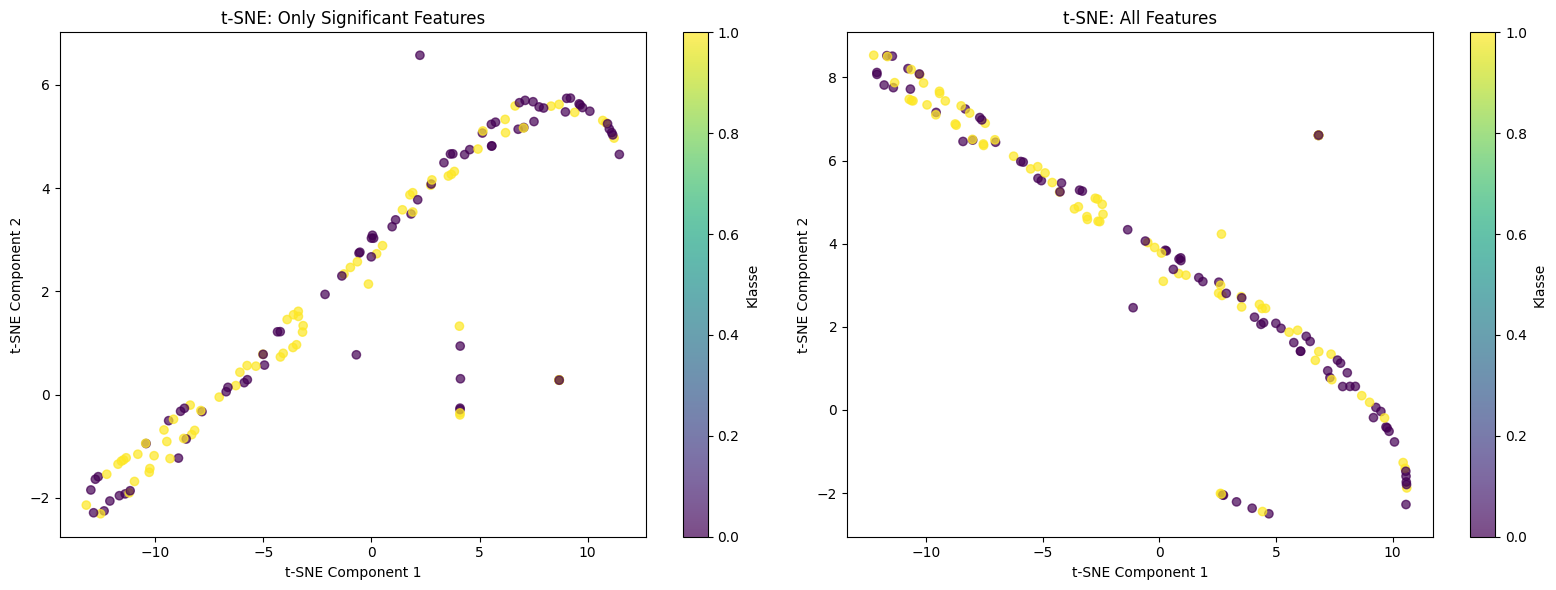

In [169]:
# ---- t-SNE Visualization: Significant vs All Features ----

# t-SNE on significant the features
tsne_sig = TSNE(n_components=2, random_state=42)
x_train_tsne_sig = tsne_sig.fit_transform(x_train_sig)

# t-SNE on all the features
tsne_all = TSNE(n_components=2, random_state=42)
x_train_tsne_all = tsne_all.fit_transform(x_train)

# Plotting side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax[0].scatter(x_train_tsne_sig[:, 0], x_train_tsne_sig[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[0].set_title("t-SNE: Only Significant Features")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter1, ax=ax[0], label='Klasse')

scatter2 = ax[1].scatter(x_train_tsne_all[:, 0], x_train_tsne_all[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[1].set_title("t-SNE: All Features")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter2, ax=ax[1], label='Klasse')

plt.tight_layout()
plt.show()


# Classifiers

In [74]:
# Collect results into a list of dictionaries
results = {}

## 1. Linear Classifier (LDA)

In [171]:
# --- Linear Discriminant Analysis (LDA) ---

# Checking the asssumption of LDA, normally distributed
normal_distributed = features_df.loc[features_df['Test'] == 't-test'].shape[0]
normal_distributed_sig = sig_features_df.loc[sig_features_df['Test'] == 't-test'].shape[0]

print(f'Total normal distributed features: {normal_distributed}')
print(f'Normal distributed + significant features: {normal_distributed_sig}')
print(f'Percentage usable for LDA: {normal_distributed_sig / len(data.columns) * 100:.2f}%')

# Selecting features aligned with the LDA assumptions
lda_feature_names = sig_features_df.loc[sig_features_df['Test'] == 't-test', 'Feature'].tolist()
x_train_lda = x_train[lda_feature_names]
x_test_lda = x_test[lda_feature_names]

# Training and evaluating LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_lda, y_train)
y_pred_lda = lda.predict(x_test_lda)
y_proba_lda = lda.predict_proba(x_test_lda)[:, 1]

# Storing the results of the classifier in results{}
results['Linear Discriminant Analysis'] = {
    'Classifier': 'Linear Discriminant Analysis',
    'Accuracy': accuracy_score(y_test, y_pred_lda),
    'ROC AUC': roc_auc_score(y_test, y_proba_lda),
    'F1 Score': f1_score(y_test, y_pred_lda),
    'Precision': precision_score(y_test, y_pred_lda),
    'Recall': recall_score(y_test, y_pred_lda)
}


Total normal distributed features: 60
Normal distributed + significant features: 30
Percentage usable for LDA: 6.07%


## 2. Quadratic Classifier (QDA)

In [172]:
# --- Quadratic Discriminant Analysis (QDA) ---

# Checking the asssumption of QDA, normally distributed
normal_distributed = features_df.loc[features_df['Test'] == 't-test'].shape[0]
normal_distributed_sig = sig_features_df.loc[sig_features_df['Test'] == 't-test'].shape[0]

print(f'Total normal distributed features: {normal_distributed}')
print(f'Normal distributed + significant features (p < 0.05): {normal_distributed_sig}')
print(f'Percentage usable for QDA: {normal_distributed_sig / len(data.columns) * 100:.2f}%')

# Selecting the features aligned with QDA assumptions
qda_feature_names = sig_features_df.loc[
    sig_features_df['Test'] == 't-test',
    'Feature'
].tolist()

x_train_qda = x_train[qda_feature_names]
x_test_qda = x_test[qda_feature_names]

# Training and evaluating the QDA classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train_qda, y_train)
y_pred_qda = qda.predict(x_test_qda)
y_proba_qda = qda.predict_proba(x_test_qda)[:, 1]

# Storing the results of the classifier in results{}
results['Quadratic Discriminant Analysis'] = {
    'Classifier': 'Quadratic Discriminant Analysis',
    'Accuracy': accuracy_score(y_test, y_pred_qda),
    'ROC AUC': roc_auc_score(y_test, y_proba_qda),
    'F1 Score': f1_score(y_test, y_pred_qda),
    'Precision': precision_score(y_test, y_pred_qda),
    'Recall': recall_score(y_test, y_pred_qda)
}

Total normal distributed features: 60
Normal distributed + significant features (p < 0.05): 30
Percentage usable for QDA: 6.07%


/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


## 3. Naive Bayes Classifier

In [173]:
# --- Naive Bayes Classifer ---

# Removing the highly correlated features for key property of NB
correlation_matrix = x_train.corr()
np.fill_diagonal(correlation_matrix.values, np.nan)

corr_threshold = 0.7 # threshold of correlation of 0.7
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Reducing the features by dropping highly correlated ones
x_train_reduced = x_train.drop(columns=to_drop)
x_test_reduced = x_test[x_train_reduced.columns]  # Match test data columns with the reduced train set

# Train Naive Bayes classifier on reduced feature set
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_reduced, y_train)

# Predictions and probabilities
y_pred_nb = nb_classifier.predict(x_test_reduced)
y_proba_nb = nb_classifier.predict_proba(x_test_reduced)[:, 1]

# Calculate evaluation metrics
nb_metrics = {
    'Classifier': 'Naive Bayes',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'ROC AUC': roc_auc_score(y_test, y_proba_nb),
    'F1 Score': f1_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb)
}

# Append results to the list
results['Naive Bayes'] = nb_metrics

## 4. k-NN Classifier

Best Parameters: {'pca__n_components': 5, 'knn__weights': 'distance', 'knn__n_neighbors': 21, 'knn__metric': 'manhattan'}
Test Accuracy: 0.4474


/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/

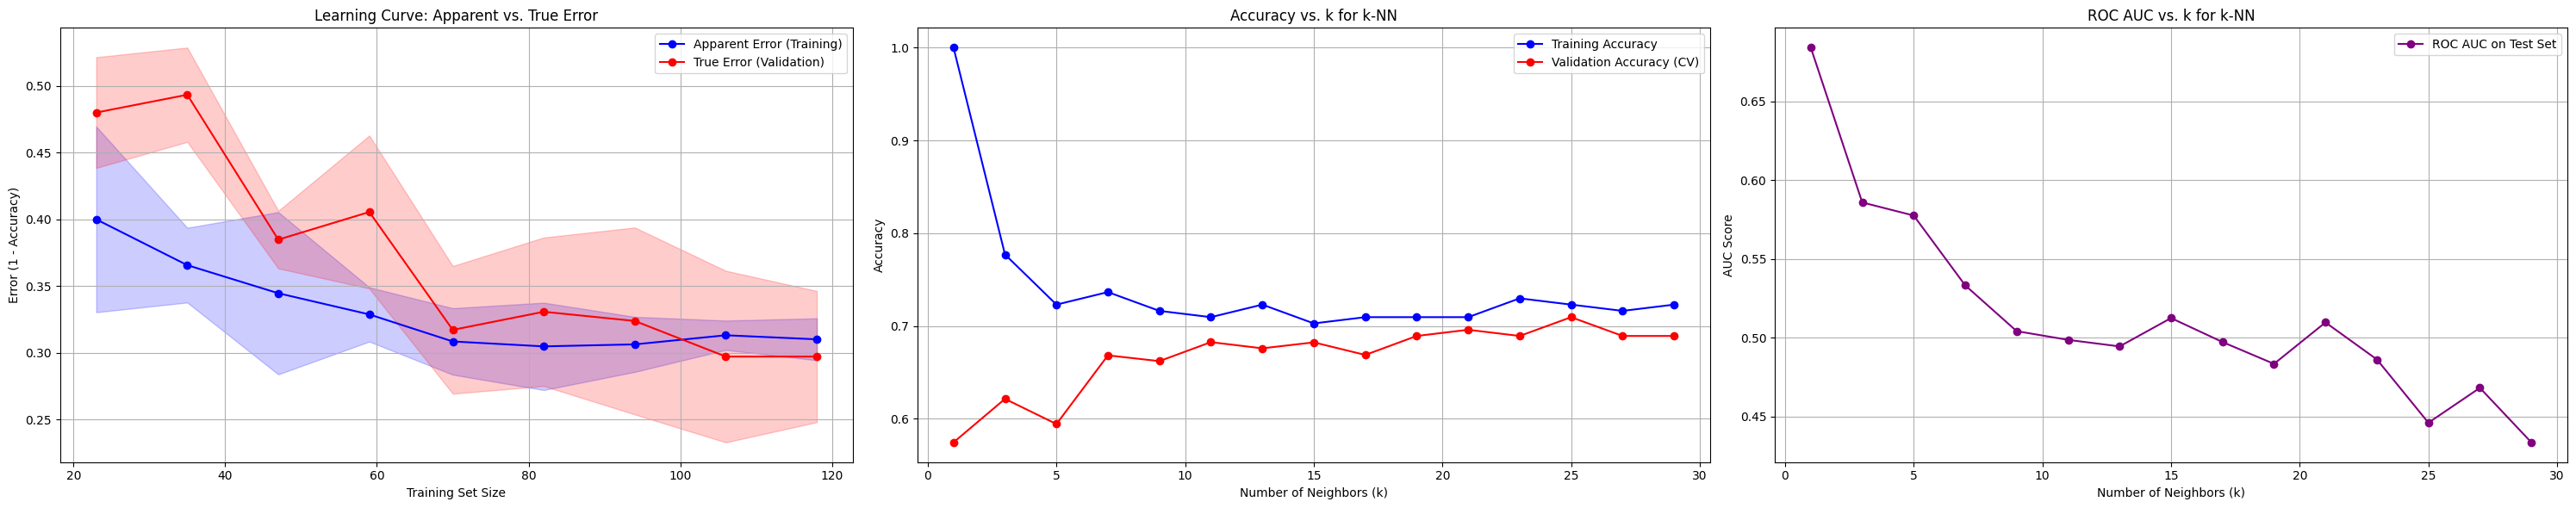

                        Classifier  Accuracy  ROC AUC  F1 Score  Precision  \
0     Linear Discriminant Analysis    0.5263   0.6870    0.5909     0.5200   
1  Quadratic Discriminant Analysis    0.6053   0.5665    0.6154     0.6000   
2                      Naive Bayes    0.4474   0.3241    0.0000     0.0000   
3              k-Nearest Neighbors    0.4474   0.5208    0.5333     0.4615   

   Recall  
0  0.6842  
1  0.6316  
2  0.0000  
3  0.6316  


In [177]:
# ---- Making the K-NN classifier ----

# Define the pipeline for kNN
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid kNN
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'knn__n_neighbors': list(range(1, 27, 2)),  # Odd k values from 1 to 25
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform hyperparameter optimization
random_grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_grid_search.fit(x_train, y_train)

# Best model evaluation
best_model = random_grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Print best parameters and test accuracy
print(f"Best Parameters: {random_grid_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---- Storing the k-NN results in results dictionary ----

# Predict probabilities for ROC AUC
y_proba_knn = best_model.predict_proba(x_test)[:, 1]

# Store metrics
results['k-NN'] = {
    'Classifier': 'k-Nearest Neighbors',
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba_knn),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
}

# ---- Evaluation of the k-NN classifier ----

# PLOT 1: Learning Curve (Apparent vs. True Error)
best_k = random_grid_search.best_params_['knn__n_neighbors']
best_pca = random_grid_search.best_params_['pca__n_components']

# Defining the final (best) pipeline
kn_pipeline = Pipeline([
    ('scaler', RobustScaler()),  
    ('pca', PCA(n_components=best_pca)),  
    ('knn', KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform'))
])

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    kn_pipeline, x_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Computing the mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Converting accuracy to error (1 - accuracy)
train_error = 1 - train_mean
val_error = 1 - val_mean

# PLOT 2: Accuracy vs. k and ROC AUC vs. k
k_values = list(range(1, 31, 2))
train_accuracies = []
val_accuracies = []
auc_scores = []

for k in k_values:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=best_pca)),  
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform'))
    ])
    
    # Cross-validation accuracy
    val_score = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy').mean()
    val_accuracies.append(val_score)

    # Train accuracy
    pipeline.fit(x_train, y_train)
    train_pred = pipeline.predict(x_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_acc)

    # ROC AUC on test set
    try:
        y_proba = pipeline.predict_proba(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
    except:
        auc_score = np.nan
    auc_scores.append(auc_score)

# Create a figure with 3 subplots next to each other (use the original comments and structure)
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

# PLOT 1: Learning Curve (Apparent vs. True Error)
axes[0].plot(train_sizes, train_error, marker='o', color='blue', label='Apparent Error (Training)')
axes[0].plot(train_sizes, val_error, marker='o', color='red', label='True Error (Validation)')
axes[0].fill_between(train_sizes, train_error - train_std, train_error + train_std, color='blue', alpha=0.2)
axes[0].fill_between(train_sizes, val_error - val_std, val_error + val_std, color='red', alpha=0.2)
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('Error (1 - Accuracy)')
axes[0].set_title('Learning Curve: Apparent vs. True Error')
axes[0].legend()
axes[0].grid(True)

# PLOT 2: Accuracy vs. k for k-NN
axes[1].plot(k_values, train_accuracies, marker='o', label='Training Accuracy', color='blue')
axes[1].plot(k_values, val_accuracies, marker='o', label='Validation Accuracy (CV)', color='red')
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs. k for k-NN')
axes[1].legend()
axes[1].grid(True)

# PLOT 3: ROC AUC vs. k for k-NN
axes[2].plot(k_values, auc_scores, marker='o', label='ROC AUC on Test Set', color='purple')
axes[2].set_xlabel('Number of Neighbors (k)')
axes[2].set_ylabel('AUC Score')
axes[2].set_title('ROC AUC vs. k for k-NN')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 5. Hard support vector machine

In [175]:
# Support vector machine ('hard)

svm_hard_pipeline = Pipeline([
    ('scaler', RobustScaler()), #robust scaler because of outliners 
    ('svm', LinearSVC(C=100, max_iter=100000))
])

validation_svm_linear = cross_val_score(svm_hard_pipeline, x_train, y_train, cv=4)

#Warning: failed to converge, not usuable 

/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 6. Soft Margin Support Vector Machine

In [180]:
#sorft margin SVM, search for the best hyperparameters

# Create a pipeline: first scaling, then the SVM classifier
svm_soft_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', SVC(probability=True))
])

param_distributions = {
    'classifier__C': np.arange(0.001, 1.0, 0.1).tolist(),   
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],                 # Relevant for rbf, poly, and sigmoid kernels
    'classifier__degree': [2, 3, 4, 5],                     # Only relevant when kernel='poly'
    'classifier__coef0': np.linspace(0, 1, 5).tolist()        # Only relevant for poly and sigmoid kernels
}

# loop over different values for hyperparameters
svm_search = RandomizedSearchCV(
    estimator=svm_soft_pipeline,
    param_distributions=param_distributions,
    n_iter=30,       # How many combinations of hyperparameters 
    cv=5,            # 5-fold cross-validation
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    refit=True,
    n_jobs=-1
)

# Execute the Randomized Search on the training data (using only significant features)
svm_search.fit(x_train, y_train)

# Print results
print("Best CV Score:", svm_search.best_score_)
print("Best Estimator:", svm_search.best_estimator_)
print("Best Parameters:", svm_search.best_params_)

# ----  Storing the the results in results{} ----

# Predict on test set
y_pred_svm = svm_search.predict(x_test)
y_proba_svm = svm_search.predict_proba(x_test)[:, 1]

# Store results in dictionary
results["Support Vector Machine"] = {
    'Classifier': 'Support Vector Machine',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'ROC AUC': roc_auc_score(y_test, y_proba_svm),
    'F1 Score': f1_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm)
}

results_df = pd.DataFrame(results.values())
print(results_df)


# Analyse op overfitting
validatie_accuracy_svm = cross_val_score(svm_search.best_estimator_, x_train, y_train, scoring='accuracy', cv=5)
train_score_svm = svm_search.score(x_train, y_train)  #accuracy score op trainingsdata 


Fitting 5 folds for each of 30 candidates, totalling 150 fits


# 6.2 Plot soft SVM results

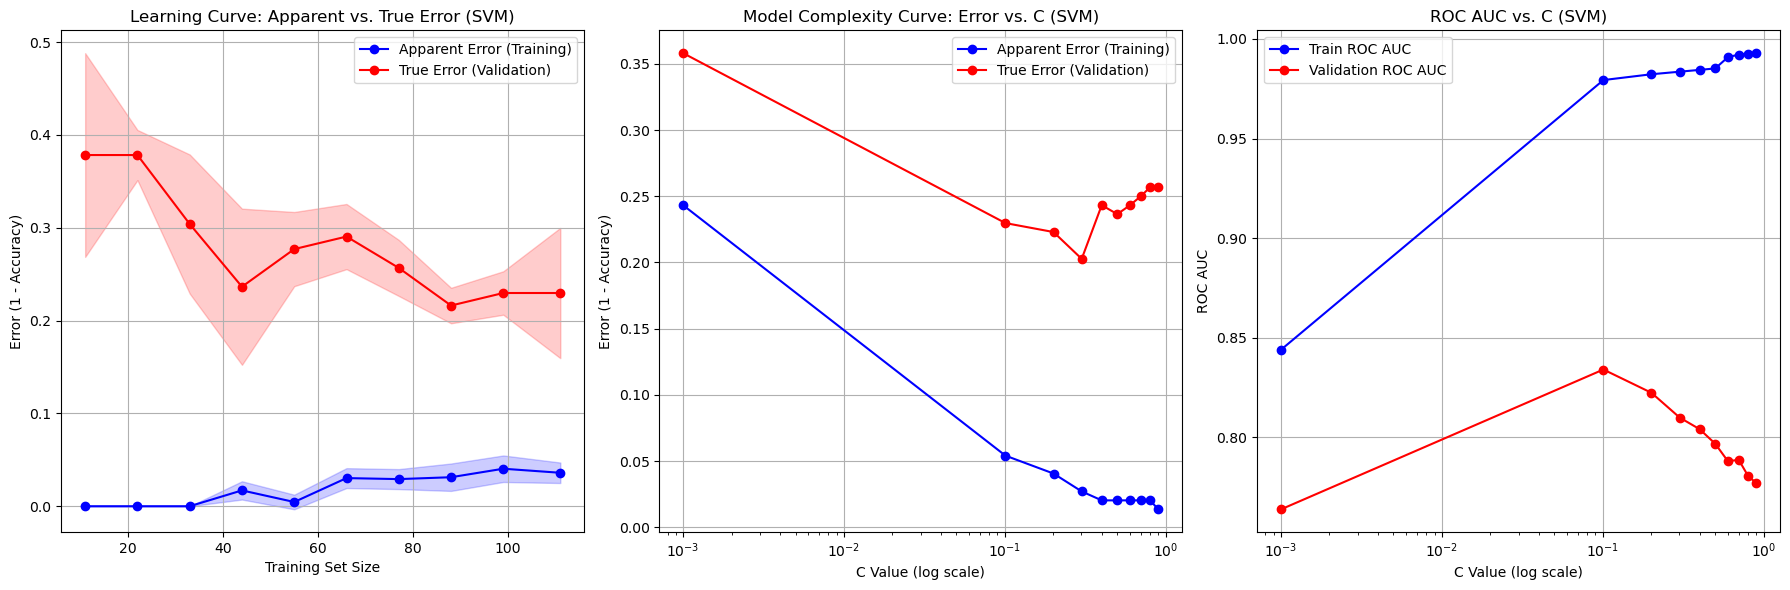

In [35]:
# --- Getting the best parameters from svm_search ---
best_params = svm_search.best_params_
best_C = best_params['classifier__C']
best_kernel = best_params['classifier__kernel']
best_gamma = best_params['classifier__gamma']

if best_kernel == 'poly':
    best_degree = best_params['classifier__degree']
    best_coef0 = best_params['classifier__coef0']
    final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma,
                      degree=best_degree, coef0=best_coef0)
else:
    final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

# Building the final pipeline
final_pipeline_soft_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model)
])

# ---- PLOT 1: Learning Curve (Apparent vs. True Error) ----
train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline_soft_svm, x_train_sig, y_train, cv=4, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Converting accuracy to the error
train_error = 1 - train_mean
val_error = 1 - val_mean

# Plotting the learning curve
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ax = axes[0]
ax.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
ax.plot(train_sizes, val_error, marker='o', label='True Error (Validation)', color='red')
ax.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
ax.fill_between(train_sizes, val_error - val_std, val_error + val_std, alpha=0.2, color='red')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Error (1 - Accuracy)')
ax.set_title('Learning Curve: Apparent vs. True Error (SVM)')
ax.legend()
ax.grid(True)


# ---- PLOT 2: Error vs. C ----
C_values = np.arange(0.001, 1.0, 0.1)
train_errors = []
val_errors = []

for C_val in C_values:
    if best_kernel == 'poly':
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma,
                    degree=best_degree, coef0=best_coef0)
    else:
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma)

    pipe = Pipeline([('scaler', RobustScaler()), ('classifier', model)])
    
    # CV Error
    val_accuracy = cross_val_score(pipe, x_train_sig, y_train, cv=4, scoring='accuracy').mean()
    val_errors.append(1 - val_accuracy)

    # Training Error
    pipe.fit(x_train_sig, y_train)
    train_accuracy = accuracy_score(y_train, pipe.predict(x_train_sig))
    train_errors.append(1 - train_accuracy)

# Plot
ax = axes[1]
ax.plot(C_values, train_errors, marker='o', linestyle='-', color='blue', label='Apparent Error (Training)')
ax.plot(C_values, val_errors, marker='o', linestyle='-', color='red', label='True Error (Validation)')
ax.set_xscale('log')
ax.set_xlabel('C Value (log scale)')
ax.set_ylabel('Error (1 - Accuracy)')
ax.set_title('Model Complexity Curve: Error vs. C (SVM)')
ax.legend()
ax.grid(True)

# ---- PLOT 3: ROC AUC vs. C ----
C_values = np.arange(0.001, 1.0, 0.1)
train_auc_list = []
cv_auc_list = []

for C_val in C_values:
    if best_kernel == 'poly':
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma, degree=best_degree, coef0=best_coef0)
    else:
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma)
    pipe = Pipeline([('scaler', RobustScaler()), ('classifier', model)])
    cv_scores = cross_val_score(pipe, x_train_sig, y_train, cv=4, scoring='roc_auc')
    pipe.fit(x_train_sig, y_train)
    train_auc = roc_auc_score(y_train, pipe.decision_function(x_train_sig))
    train_auc_list.append(train_auc)
    cv_auc_list.append(np.mean(cv_scores))

ax = axes[2]
ax.plot(C_values, train_auc_list, marker='o', linestyle='-', label='Train ROC AUC', color='blue')
ax.plot(C_values, cv_auc_list, marker='o', linestyle='-', label='Validation ROC AUC', color='red')
ax.set_xscale('log')
ax.set_xlabel('C Value (log scale)')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs. C (SVM)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()




# 7. Random forest classifier

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': False}
Validation Scores: [0.86666667 0.7        0.66666667 0.51724138 0.72413793]
Mean validation score: 0.6949425287356321
train:0.9932432432432432
Selected Features:, ['PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_hf_range', 'PREDICT_original_hf_energy', 'PREDICT_original_logf_min_sigma1', 'PREDICT_original_logf_max_sigma1', 'PREDICT_original_logf_mean_sigma1', 'PREDICT_original_logf_median_sigma1', 'PREDICT_original_logf_std_sigma1', 'PREDICT_original_logf_kurtosis_sigma1', 'PREDICT_original_logf_peak_sigma1', 'PREDICT_original_logf_range_sigma1', 'PREDICT_original_logf_quartile_range_sigma1', 'PREDICT_original_logf_std_sigma5', 'PREDICT_original_logf_quartile_range_s

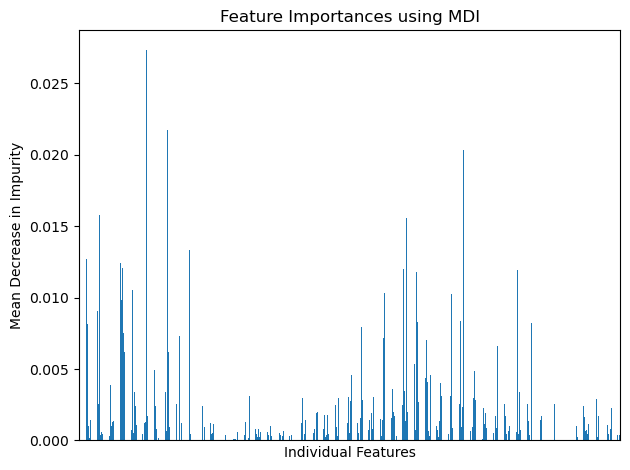

In [75]:
# Hyperparameter search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'bootstrap': [True, False]
}

# Making random forest classifier
rf = RandomForestClassifier()

# Performing grid search with 5-fold cross-validation and suppress verbose output
random_grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='accuracy')

# Fitting the grid search to the data (using x_train and y_train)
random_grid_search.fit(x_train, y_train)

# Getting the best model from the random search
best_rf = random_grid_search.best_estimator_
best_rf_selected = random_grid_search.best_estimator_

# Printing the best hyperparameters
print(f'Best Hyperparameters: {random_grid_search.best_params_}')

# Evaluating the best model on the validation set using cross-validation
best_rf.fit(x_train, y_train)
validation_rf = cross_val_score(estimator=best_rf, X=x_train, y=y_train, cv=5)
train_score_rf = best_rf.score(x_train, y_train)

print(f'Validation Scores: {validation_rf}')
print(f'Mean validation score: {np.mean(validation_rf)}')
print(f'train:{train_score_rf}')

# Plotting feature importance
importances = best_rf.feature_importances_

# Assuming x_train is a DataFrame, extract the feature names from it
feature_names = x_train.columns

# Create a Series of feature importances
forest_importances = pd.Series(importances, index=feature_names)

# Plotting the feature importances
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Individual Features")
plt.xticks([])
fig.tight_layout()

# Making a list with the names of the selected features (those with importance > 0.005)
selected_feature_names = [name for name, value in zip(feature_names, forest_importances) if value > 0.005]
print(f'Selected Features:, {selected_feature_names}')
print(f'Number of selected features: {len(selected_feature_names)}')

# Selecting the data of only the selected features (this step is optional if you choose not to filter features)
x_train_selected = x_train[selected_feature_names]

# Refiting the classifier on the selected features (for consistency)
best_rf_selected.fit(x_train_selected, y_train)
validation_rf_selected = cross_val_score(estimator=best_rf_selected, X=x_train_selected, y=y_train, cv=5)
train_score_rf_selected = best_rf_selected.score(x_train_selected,y_train)  # Accuracy score on training data (with selected features)

print(f'Validation Scores (selected features): {validation_rf_selected}')
print(f'Mean validation Score (selected features): {np.mean(validation_rf_selected)}')
print(f'train selected:{train_score_rf_selected}')


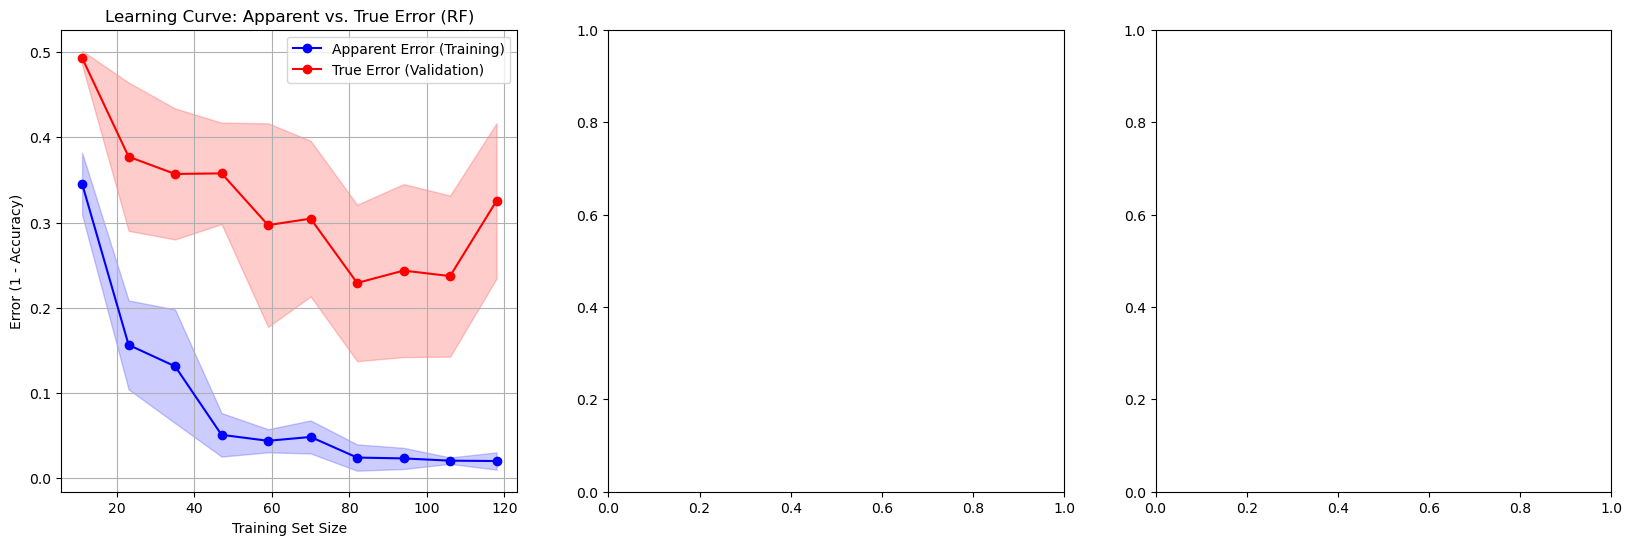

In [76]:

#plotting 
# --- LEARNING CURVE --- 
train_sizes, train_scores, valid_scores = learning_curve(
    best_rf, x_train_selected, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Convert accuracy to error
train_error = 1 - train_mean
valid_error = 1 - valid_mean

# Plot all three figures side by side in one figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Learning Curve (Error vs. Training Set Size)
axes[0].plot(train_sizes, train_error, marker='o', color='blue', label='Apparent Error (Training)')
axes[0].fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
axes[0].plot(train_sizes, valid_error, marker='o', color='red', label='True Error (Validation)')
axes[0].fill_between(train_sizes, valid_error - valid_std, valid_error + valid_std, alpha=0.2, color='red')
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('Error (1 - Accuracy)')
axes[0].set_title('Learning Curve: Apparent vs. True Error (RF)')
axes[0].legend()
axes[0].grid(True)

# Results of all classifiers

In [42]:
results_df = pd.DataFrame(results.values())
results_df = results_df.round(4)
print(results_df)

# SVM
print("Best CV Score SVM (ROC):", svm_search.best_score_) #= roc score, geen accuracy
print(f"Training score SVM: {train_score_svm}")
print("Accuracy validatie SVM:", validatie_accuracy_svm )
print(f'Difference training & validation SVM: {train_score_svm-np.mean(validatie_accuracy_svm)}\n')


# Rf
print(f'Validation score RF (after feature selection): {np.mean(validation_rf_selected)}')
print(f"Training score RF: {train_score_rf}")
print(f'Difference between training & validation RF (before feature selection): {train_score_rf - np.mean(validation_rf)}')
print(f'Difference between training & validation RF (after feature selection): {train_score_rf - np.mean(validation_rf_selected)}')


                        Classifier  Accuracy  ROC AUC  F1 Score  Precision  \
0     Linear Discriminant Analysis    0.5263   0.6870    0.5909       0.52   
1  Quadratic Discriminant Analysis    0.6053   0.5665    0.6154       0.60   
2                      Naive Bayes    0.4474   0.3241    0.0000       0.00   
3              k-Nearest Neighbors    0.5000   0.5665    0.5128       0.50   

   Recall  
0  0.6842  
1  0.6316  
2  0.0000  
3  0.5263  
Best CV Score SVM (ROC): 0.7575873015873016
Training score SVM: 1.0
Accuracy validatie SVM: [0.73333333 0.8        0.66666667 0.72413793 0.68965517]
Difference training & validation SVM: 0.27724137931034487

Validation score RF (after feature selection): 0.7970114942528737
Training score RF: 1.0
Difference between training & validation RF (before feature selection): 0.2232183908045977
Difference between training & validation RF (after feature selection): 0.20298850574712635


# Regulation

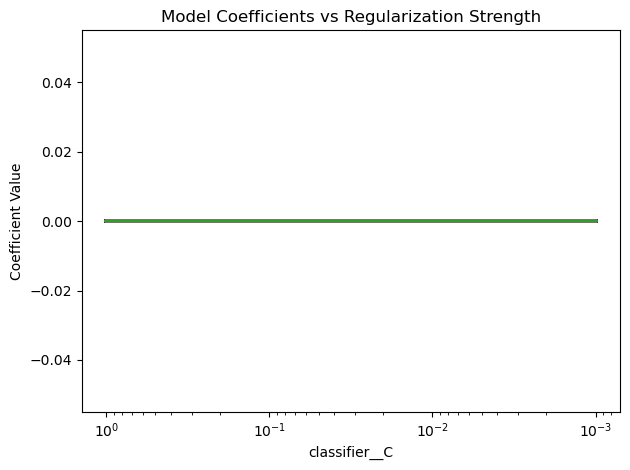

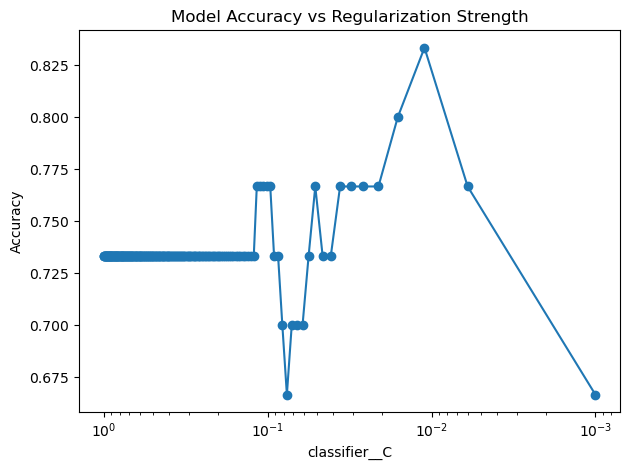

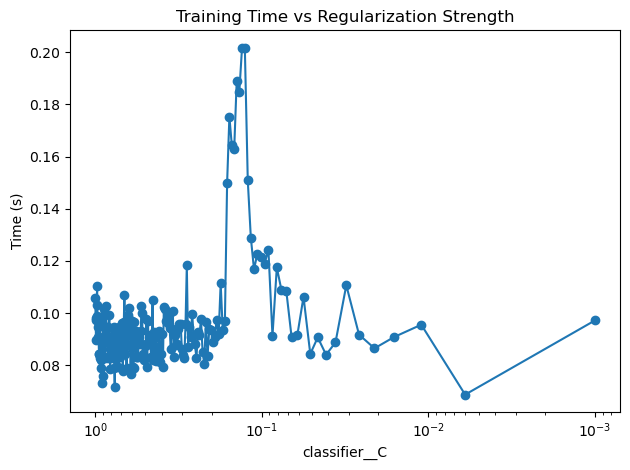

Best alpha for soft SVM: 0.011040201005025126
Best Accuracy for soft SVM: 0.8333333333333334


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.base import clone
from sklearn.metrics import accuracy_score

def l2_regularization(model, X_train, X_val, y_train, y_val, alpha_name='alpha', plot=True):
    """
    Runs L2 regularization analysis on a model.

    Parameters:
        model (sklearn classifier): The base model to be cloned and fitted
        X_train, X_val, y_train, y_val: Data splits
        alpha_name (str): Either 'alpha' or 'C', depending on the model
        plot (bool): Whether to generate performance plots

    Returns:
        results (dict): Dictionary containing alphas, accuracies, times, coefs, best_alpha, best_accuracy
    """
    # Calculate error for multiple alphas 
    #n_alphas = 200
    alphas = np.linspace(0.001, 1, 200)
    
    # Initialize lists to collect results
    coefs = []
    accuracies = []
    times = []

    best_alpha = None
    best_accuracy = -np.inf  # Initialize with a very low accuracy
    
    for a in alphas:
        # Clone the model pipeline (to avoid fitting the same model multiple times)
        cloned_pipeline = clone(model)

        # Set the alpha parameter for the SVC model in the pipeline
        cloned_pipeline.set_params(**{alpha_name: a})

        t0 = time.time()
        cloned_pipeline.fit(X_train, y_train)
        duration = time.time() - t0

        # Use validation data to evaluate the model
        y_pred = cloned_pipeline.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        times.append(duration)
        accuracies.append(acc)
        coefs.append(cloned_pipeline.coef_ if hasattr(cloned_pipeline, "coef_") else np.zeros(X_train.shape[1]))

        # Track the best alpha based on highest accuracy
        if acc > best_accuracy:
            best_accuracy = acc
            best_alpha = a
        

    if plot:
        # Coefficients plot
        plt.figure()
        plt.plot(alphas, np.squeeze(coefs))
        plt.xscale('log')
        plt.gca().invert_xaxis()
        plt.title('Model Coefficients vs Regularization Strength')
        plt.xlabel(alpha_name)
        plt.ylabel('Coefficient Value')
        plt.tight_layout()
        plt.show()

        # Accuracy plot
        plt.figure()
        plt.plot(alphas, accuracies, marker='o')
        plt.xscale('log')
        plt.gca().invert_xaxis()
        plt.title('Model Accuracy vs Regularization Strength')
        plt.xlabel(alpha_name)
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

        # Time plot
        plt.figure()
        plt.plot(alphas, times, marker='o')
        plt.xscale('log')
        plt.gca().invert_xaxis()
        plt.title('Training Time vs Regularization Strength')
        plt.xlabel(alpha_name)
        plt.ylabel('Time (s)')
        plt.tight_layout()
        plt.show()

    # Return the results including best_alpha and best_accuracy
    return {
        'alphas': alphas,
        'accuracies': accuracies,
        'times': times,
        'coefs': coefs,
        'best_alpha': best_alpha,
        'best_accuracy': best_accuracy
    }

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42  # 20% for validation, 80% for training
)
    
    # Train the model on each fold
results_svm_soft = l2_regularization(
    model=final_pipeline_soft_svm,
    X_train=X_train_split,
    X_val=X_val_split,
    y_train=y_train_split,
    y_val=y_val_split,
    alpha_name='classifier__C'
    )

# Print the best alpha and accuracy for each model
print(f"Best alpha for soft SVM: {results_svm_soft['best_alpha']}")
print(f"Best Accuracy for soft SVM: {results_svm_soft['best_accuracy']}")


# Performance models

In [ ]:
# Scoring variables
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, cross_validate

scoring = ['accuracy', 'roc_auc']

## missende pipelines doe het nu hier maar handiger in fucnties zelf
lda_pipeline = Pipeline([
    ('lda', LinearDiscriminantAnalysis())
])
qda_pipeline = Pipeline([
    ('qda', QuadraticDiscriminantAnalysis())
])
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2))
])
nb_pipeline = Pipeline([
    ('nb', GaussianNB())
])

# Cross-validation WSS AL IN CLASSIFIERS ZELF
lda_scores = cross_validate(lda_pipeline, x_train_sig, y_train, cv=5, scoring=scoring)
qda_scores = cross_validate(qda_pipeline, x_train_sig, y_train, cv=5, scoring=scoring)
svm_hard_scores = cross_validate(svm_hard_pipeline, x_train_sig, y_train, cv=5, scoring=scoring) #pl naam aangepast in code
svm_soft_scores = cross_validate(final_pipeline_soft_svm, x_train_sig, y_train, cv=5, scoring=scoring) #''
rf_scores = cross_validate(rf_pipeline, x_train_sig_selected, y_train, cv=5, scoring=scoring)
kn_scores = cross_validate(kn_pipeline, x_train_sig, y_train, cv=5, scoring=scoring) # ''
nb_scores = cross_validate(nb_pipeline, x_train_reduced, y_train, cv=5, scoring=scoring)

# Calculate mean accuracy and ROC AUC for all models
lda_avg_accuracy = np.mean(lda_scores['test_accuracy'])
lda_avg_roc_auc = np.mean(lda_scores['test_roc_auc'])

qda_avg_accuracy = np.mean(qda_scores['test_accuracy'])
qda_avg_roc_auc = np.mean(qda_scores['test_roc_auc'])

svm_hard_avg_accuracy = np.mean(svm_hard_scores['test_accuracy'])
svm_hard_avg_roc_auc = np.mean(svm_hard_scores['test_roc_auc'])

svm_soft_avg_accuracy = np.mean(svm_soft_scores['test_accuracy'])
svm_soft_avg_roc_auc = np.mean(svm_soft_scores['test_roc_auc'])

rf_avg_accuracy = np.mean(rf_scores['test_accuracy'])
rf_avg_roc_auc = np.mean(rf_scores['test_roc_auc'])

knn_avg_accuracy = np.mean(kn_scores['test_accuracy'])
knn_avg_roc_auc = np.mean(kn_scores['test_roc_auc'])

nb_avg_accuracy = np.mean(nb_scores['test_accuracy'])
nb_avg_roc_auc = np.mean(nb_scores['test_roc_auc'])

# print mean and standard deviation
# LDA
print("LDA Accuracy: {:.3f} ± {:.3f}".format(lda_avg_accuracy, np.std(lda_scores['test_accuracy'])))
print("LDA ROC AUC: {:.3f} ± {:.3f}".format(lda_avg_roc_auc, np.std(lda_scores['test_roc_auc'])))

# QDA
print("QDA Accuracy: {:.3f} ± {:.3f}".format(qda_avg_accuracy, np.std(qda_scores['test_accuracy'])))
print("QDA ROC AUC: {:.3f} ± {:.3f}".format(qda_avg_roc_auc, np.std(qda_scores['test_roc_auc'])))

# SVM (hard margin)
print("SVM (Hard Margin) Accuracy: {:.3f} ± {:.3f}".format(svm_hard_avg_accuracy, np.std(svm_hard_scores['test_accuracy'])))
print("SVM (Hard Margin) ROC AUC: {:.3f} ± {:.3f}".format(svm_hard_avg_roc_auc, np.std(svm_hard_scores['test_roc_auc'])))

# SVM (soft margin)
print("SVM (Soft Margin) Accuracy: {:.3f} ± {:.3f}".format(svm_soft_avg_accuracy, np.std(svm_soft_scores['test_accuracy'])))
print("SVM (Soft Margin) ROC AUC: {:.3f} ± {:.3f}".format(svm_soft_avg_roc_auc, np.std(svm_soft_scores['test_roc_auc'])))

# Random Forest
print("Random Forest Accuracy: {:.3f} ± {:.3f}".format(rf_avg_accuracy, np.std(rf_scores['test_accuracy'])))
print("Random Forest ROC AUC: {:.3f} ± {:.3f}".format(rf_avg_roc_auc, np.std(rf_scores['test_roc_auc'])))

# KNN
print("KNN Accuracy: {:.3f} ± {:.3f}".format(knn_avg_accuracy, np.std(kn_scores['test_accuracy'])))
print("KNN ROC AUC: {:.3f} ± {:.3f}".format(knn_avg_roc_auc, np.std(kn_scores['test_roc_auc'])))

# Naive Bayes
print("Naive Bayes Accuracy: {:.3f} ± {:.3f}".format(nb_avg_accuracy, np.std(nb_scores['test_accuracy'])))
print("Naive Bayes ROC AUC: {:.3f} ± {:.3f}".format(nb_avg_roc_auc, np.std(nb_scores['test_roc_auc'])))

# Create dictionary of models and their mean scores
models = {
    'LDA': {'accuracy': lda_avg_accuracy, 'roc_auc': lda_avg_roc_auc},
    'QDA': {'accuracy': qda_avg_accuracy, 'roc_auc': qda_avg_roc_auc},
    'SVM (Hard)': {'accuracy': svm_hard_avg_accuracy, 'roc_auc': svm_hard_avg_roc_auc},
    'SVM (Soft)': {'accuracy': svm_soft_avg_accuracy, 'roc_auc': svm_soft_avg_roc_auc},
    'Random Forest': {'accuracy': rf_avg_accuracy, 'roc_auc': rf_avg_roc_auc},
    'KNN': {'accuracy': knn_avg_accuracy, 'roc_auc': knn_avg_roc_auc},
    'Naive Bayes': {'accuracy': nb_avg_accuracy, 'roc_auc': nb_avg_roc_auc}
}

# Search for models with highest accuracy and ROC AUC
best_accuracy_model = max(models, key=lambda x: models[x]['accuracy'])
best_roc_auc_model = max(models, key=lambda x: models[x]['roc_auc'])

# Print best models
print(f"Best model by Accuracy: {best_accuracy_model} ({models[best_accuracy_model]['accuracy']:.3f})")
print(f"Best model by ROC AUC: {best_roc_auc_model} ({models[best_roc_auc_model]['roc_auc']:.3f})")




c:\Users\manon\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\manon\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\manon\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\manon\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


NameError: name 'x_train_sig_selected' is not defined

# Final for-loop

In [ ]:
def split_test_data(x, y, random_state, test_size=0.2):
    """
    Splits the data (features x and labels y) into training and testing sets.
    
    Parameters:
    x :             The input feature set (DataFrame).
    y :             The target labels (DataFrame)
    random_state :  The seed used by the random number generator for reproducibility (int).
    test_size :     The proportion of the data to be used as the test set (float, optional (default=0.2)).

    Returns:
    x_train, x_test, y_train, y_test : The training and test splits for both features and labels (arrays).
    """
    # Splitting data into train and test sets based on the specified random state
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Printing the shape of the datasets
    print(f"The shapes of the datasets for random_state={random_state} are:")
    print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
    
    return x_train, x_test, y_train, y_test


## final for loop

y = num_data['label']
x = num_data.drop(columns=['label'])

for i in range(1,6):
    split_test_data(x, y, i, 0.2)


## voorbeeld met kn classifier 

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def split_test_data(x, y, random_state, test_size=0.2):
    """
    Splits the data (features x and labels y) into training and testing sets.
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
    print(f"The shapes of the datasets for random_state={random_state} are:")
    print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
    return x_train, x_test, y_train, y_test

# Assuming num_data is your dataframe with 'label' column
y = num_data['label']
x = num_data.drop(columns=['label'])

# KNN parameters
k = 5  # Example for the number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)

# Loop through splits and train/evaluate KNN
for i in range(1, 6):
    # Split the data
    x_train, x_test, y_train, y_test = split_test_data(x, y, i, 0.2)
    
    # Fit KNN model
    knn.fit(x_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the accuracy for this random_state
    print(f"Accuracy for random_state={i}: {accuracy:.4f}\n")